<a href="https://colab.research.google.com/github/woojin9605/Practice/blob/main/Classifier_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIFAR-10 Classifier

VGG-16을 CIFAR-10데이터에 맞게 레이어 수정하여 구현

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils

import numpy as np
import matplotlib.pyplot as plt
import random

manualseed = 999 # random seed 고정
random.seed(manualseed) # for numpy
torch.manual_seed(manualseed) # for torch

In [2]:
# load train dataset

BatchSize = 64

transform = T.Compose([
              T.ToTensor(),
              T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
]) # 데이터 정규화

cifar10_train = dset.CIFAR10(root='./CIFAR-10',train=True,
                             download=True,transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=BatchSize)

cifar10_test = dset.CIFAR10('./CIFAR-10/',train=False,
                           download=True,transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=BatchSize)

classes = ('plane','car','bird','cat',
           'deer','dog','frog','horse','ship','truck')

dtype = torch.float32
device = torch.device('cuda')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# model architecture 및 optimizer 정의

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model = None
optimizer = None
learning_rate = 1e-4
betas = [0.9, 0.999]

layers_key = [64, 64, 'M', 128, 128, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 512, 'M']
layers = [] # 대부분의 레이어는 유지. MaxPool 레이어만 제거
in_channels = 3

for i in layers_key: # generate nn.Sequential layers
  if i == 'M':
    layers += [nn.MaxPool2d(2,2)]
  else:
    layers += [nn.Conv2d(in_channels,i,3,padding=1), nn.BatchNorm2d(i), nn.ReLU()]
    in_channels = i

#print(layers)

model = nn.Sequential(
    *layers,
    Flatten(),
    nn.Linear(512*4*4,4096),
    nn.ReLU(),
    nn.Dropout(), # default p = 0.5
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,10)
)

print(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): Conv2d(256, 256

In [4]:
# training model

model = model.to(device=device)
print_every = 1000
epochs = 10
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.8) # lr decay

for e in range(epochs): # training
  for t,(x,y) in enumerate(loader_train):
    model.train() #model contain batchnorm, dropout etc. 모델에게 train상태임을 알려줌
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)

    scores = model(x)
    loss = F.cross_entropy(scores,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_every == 0:
      print('iter %d, loss = %.4f' % (t, loss.item()))
  lr_sche.step()

print('training finished, loss = %.4f' % loss.item())

iter 0, loss = 2.3148
iter 0, loss = 1.1516
iter 0, loss = 0.9488
iter 0, loss = 0.8059
iter 0, loss = 0.5852
iter 0, loss = 0.3691
iter 0, loss = 0.3322
iter 0, loss = 0.3094
iter 0, loss = 0.2254
iter 0, loss = 0.1458
training finished, loss = 0.0452


In [5]:
# accuracy test

model.eval()
num_correct = 0
num_samples = 0

for (x,y) in loader_test:
      x = x.to(device=device, dtype=dtype)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      _, predicts = torch.max(scores,dim=1)

      num_correct += torch.sum(predicts == y)
      num_samples += predicts.size(0)

acc = float(num_correct) / num_samples
print('correct : %d / %d , acc (%.2f)' % (num_correct,num_samples,100*acc))

correct : 8178 / 10000 , acc (81.78)


Ground_Truth :    cat ship shipplane frog frog  car frog  cat  carplanetruck  doghorsetruck ship  doghorse ship froghorseplane deertruck  dog bird deerplanetruck frog frog  dog deer  dogtruck bird deer  cartruck  dog deer frog  dog frogplanetruck  cattruckhorse frogtruck shipplane  cat ship shiphorsehorse deer froghorse  cat frog  cat
Predicted    :    cat ship shipplane frog frog  car frog  cat  carplanetruck  doghorsetruck ship  doghorse ship froghorseplane deertruck  dog bird deerplanetruck frog frog  dog deer  dogtruck bird deer  cartruck  dog deer frog  dog frogplanetruck  cattruckhorse frogtruck shipplane  cat ship shiphorsehorse deer froghorse  cat frog  cat


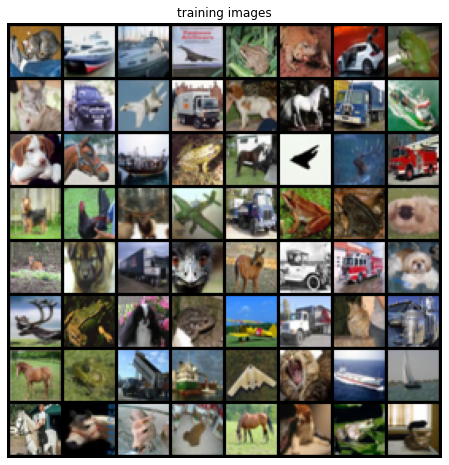

In [6]:
# compare ground_truth and predicted

x, y = next(iter(loader_test))
x = x.to(device=device, dtype=dtype)
y = y.to(device=device, dtype=torch.long)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(torchvision.utils.make_grid(x[:64],
                             padding=2,normalize=True).cpu(),(1,2,0)))

print('Ground_Truth : ',''.join('%5s' % classes[y[j]] for j in range(BatchSize)))

scores = model(x)
_, predicted = torch.max(scores,1)
print('Predicted    : ',''.join('%5s' % classes[y[j]] for j in range(BatchSize)))